# Recurrent Neural Networks: Sequence tagging

## Imports

In [44]:
import sys
import regex as re
import numpy as np
from numpy.linalg import norm
from scipy.spatial.distance import cosine
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, Dropout, Lambda, TimeDistributed
from keras.layers import LSTM, Bidirectional, SimpleRNN, BatchNormalization
from keras.models import Model
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.activations import softmax
from keras.models import load_model


EPOCHS = 15
LSTM_UNITS = 100

## Collecting a Dataset

1. You will use a dataset from the CoNLL conferences that benchmark natural language processing systems and tasks. There were two conferences on named entity recognition: <a href="https://www.clips.uantwerpen.be/conll2002/ner/">CoNLL 2002</a> (Spanish and Dutch) and <a href="https://www.clips.uantwerpen.be/conll2003/ner/">CoNLL 2003</a> (English and German). In this assignment, you will work on the English dataset. Read the description of the task.
2. The datasets are protected by a license and you need to obtain it to reconstruct the data. Alternatively, you can try to find one on github (type conll2003 in the search box) or use the Google dataset search: <a href="https://toolbox.google.com/datasetsearch">https://toolbox.google.com/datasetsearch</a>.
3. The dataset comes in the form of three files: a training set, a development set, and a test set. <!--, named:
    <tt>eng.train</tt>, <tt>eng.testa</tt> (validation), and <tt>eng.testb</tt> (test).-->

## Reading the Corpus

You will read the corpus with the cells below. The functions will enable you to load the files in the form of a list of dictionaries.

In [2]:
BASE_DIR = './conll2003/'

In [3]:
def load_conll2003_en():
    train_file = BASE_DIR + 'train.txt'
    dev_file = BASE_DIR + 'valid.txt'
    test_file = BASE_DIR + 'test.txt'
    column_names = ['form', 'ppos', 'pchunk', 'ner']
    train_sentences = open(train_file, encoding='utf8').read().strip()
    dev_sentences = open(dev_file, encoding='utf8').read().strip()
    test_sentences = open(test_file, encoding='utf8').read().strip()
    return train_sentences, dev_sentences, test_sentences, column_names

In [4]:
train_sentences, dev_sentences, test_sentences, column_names = load_conll2003_en()
train_sentences[:100]

'-DOCSTART- -X- -X- O\n\nEU NNP B-NP B-ORG\nrejects VBZ B-VP O\nGerman JJ B-NP B-MISC\ncall NN I-NP O\nto T'

In [5]:
class Token(dict):
    pass


class CoNLLDictorizer:

    def __init__(self, column_names, sent_sep='\n\n', col_sep=' +'):
        self.column_names = column_names
        self.sent_sep = sent_sep
        self.col_sep = col_sep

    def fit(self):
        pass

    def transform(self, corpus):
        corpus = corpus.strip()
        sentences = re.split(self.sent_sep, corpus)
        return list(map(self._split_in_words, sentences))

    def fit_transform(self, corpus):
        return self.transform(corpus)

    def _split_in_words(self, sentence):
        rows = re.split('\n', sentence)
        return [Token(dict(zip(self.column_names,
                               re.split(self.col_sep, row))))
                for row in rows]

In [6]:
conll_dict = CoNLLDictorizer(column_names, col_sep=' +')
train_dict = conll_dict.transform(train_sentences)
dev_dict = conll_dict.transform(dev_sentences)
test_dict = conll_dict.transform(test_sentences)

In [7]:
print(train_dict[0])
print('\n'.join(map(str, train_dict[1])))

[{'form': '-DOCSTART-', 'ppos': '-X-', 'pchunk': '-X-', 'ner': 'O'}]
{'form': 'EU', 'ppos': 'NNP', 'pchunk': 'B-NP', 'ner': 'B-ORG'}
{'form': 'rejects', 'ppos': 'VBZ', 'pchunk': 'B-VP', 'ner': 'O'}
{'form': 'German', 'ppos': 'JJ', 'pchunk': 'B-NP', 'ner': 'B-MISC'}
{'form': 'call', 'ppos': 'NN', 'pchunk': 'I-NP', 'ner': 'O'}
{'form': 'to', 'ppos': 'TO', 'pchunk': 'B-VP', 'ner': 'O'}
{'form': 'boycott', 'ppos': 'VB', 'pchunk': 'I-VP', 'ner': 'O'}
{'form': 'British', 'ppos': 'JJ', 'pchunk': 'B-NP', 'ner': 'B-MISC'}
{'form': 'lamb', 'ppos': 'NN', 'pchunk': 'I-NP', 'ner': 'O'}
{'form': '.', 'ppos': '.', 'pchunk': 'O', 'ner': 'O'}


## Evaluating your Models

You will train the models with the traing set and the test set to evaluate them. For this, you will apply the `conlleval` script that will compute the harmonic mean of the precision and recall: F1. 

`conlleval` was written in Perl, and some people rewrote it in Python and you will use such such a translation in this lab. The line below installs it.

In [8]:
!pip install conlleval
import conlleval

## Collecting the Embeddings

You will represent the words with the GloVe embeddings:
1. Download the GloVe embeddings 6B from <a href="https://nlp.stanford.edu/projects/glove/">https://nlp.stanford.edu/projects/glove/</a> and keep the 100d vectors.
2. Apply a function that reads GloVe embeddings and store them in a dictionary, where the keys will be the words and the values, the embeddings.

In [9]:
embedding_file = './glove.6B/glove.6B.100d.txt'

In [10]:
def read_embeddings(file):
    """
    Return the embeddings in the from of a dictionary
    :param file:
    :return:
    """
    embeddings = {}
    glove = open(file, encoding='utf8')
    for line in glove:
        values = line.strip().split()
        word = values[0]
        vector = np.array(values[1:], dtype='float32')
        embeddings[word] = vector
    glove.close()
    return embeddings

In [11]:
# We read the embeddings
embeddings_dict = read_embeddings(embedding_file)
embedded_words = sorted(list(embeddings_dict.keys()))
print('# words in embedding dictionary:', len(embedded_words))

# words in embedding dictionary: 400000


Using a cosine similarity, write a `closest(target_word, embeddings, count=10)` that computes the 5 closest words to the words _table_, _france_, and _sweden_

In [12]:
def cosine_similarity(vec1, vec2):
    dot = np.dot(vec1, vec2)
    norm1 = np.sqrt(np.sum(np.dot(vec1, vec1)))
    norm2 = np.sqrt(np.sum(np.dot(vec2, vec2)))
    cos = dot / (norm1 * norm2)
    return cos

In [13]:
import heapq
def closest(target_word, embeddings, count=10):
    target = target_word.lower()
    target_vec = embeddings[target]
    closest_words = {}
    distances = []
    for w in embeddings.keys():
        vec = embeddings[w]
        cos_sim = cosine_similarity(vec, target_vec)
        heapq.heappush(distances, cos_sim)
        closest_words[cos_sim] = w
        if len(distances) == count + 1:
            key = heapq.heappop(distances)
            del closest_words[key]
    return [closest_words[i] for i in reversed(sorted(closest_words.keys()))]

In [14]:
closest('table', embeddings_dict, count=10)

['table',
 'tables',
 'place',
 'bottom',
 'room',
 'side',
 'sit',
 'top',
 'here',
 'pool']

In [15]:
closest('france', embeddings_dict, count=10)

['france',
 'belgium',
 'french',
 'britain',
 'spain',
 'paris',
 'germany',
 'italy',
 'europe',
 'netherlands']

In [16]:
closest('sweden', embeddings_dict, count=5)

['sweden', 'denmark', 'norway', 'finland', 'netherlands']

## Extracting the $\mathbf{X}$ and $\mathbf{Y}$ Lists of Symbols

Write a `build_sequences(corpus_dict, key_x='form', key_y='ner', tolower=True)` function that for each sentence returns the $\mathbf{x}$ and $\mathbf{y}$ lists of symbols consisting of words and NER tags.

In [17]:
def build_sequences(corpus_dict, key_x='form', key_y='ner', tolower=True):
    X, Y = [], []
    for sentence in corpus_dict:
        x, y = [], []
        for row in sentence:
            x.append(row[key_x].lower()) if tolower else x.append(row[key_x])
            y.append(row[key_y])
        X.append(x)
        Y.append(y)
    return X, Y

Apply this function to your datasets so that you create $\mathbf{X}$ and $\mathbf{Y}$ lists of lists consisting of words and NER tags
        
For the second sentence of the training set, you should have:<br/>
<tt>x = ['eu', 'rejects', 'german', 'call', 'to', 'boycott', 'british', 'lamb', '.']</tt><br/>
<tt>y = ['I-ORG', 'O', 'I-MISC', 'O', 'O', 'O', 'I-MISC', 'O', 'O']</tt><br/>
Some datasets you may find on the web use a different NER tagset, where <tt>I-</tt> is
replaced with <tt>B-</tt>, like <tt>B-ORG</tt> instead of <tt>I-ORG</tt>. This will not change the results.

In [18]:
X, Y = build_sequences(train_dict, key_x='form', key_y='ner')
print('First sentence, words', X[1])
print('First sentence, NER', Y[1])

First sentence, words ['eu', 'rejects', 'german', 'call', 'to', 'boycott', 'british', 'lamb', '.']
First sentence, NER ['B-ORG', 'O', 'B-MISC', 'O', 'O', 'O', 'B-MISC', 'O', 'O']


## Vocabulary

Create a vocabulary of all the words observed in the training set and the words in GloVe. You should find 402,595 different words. You will proceed in two steps.

First extract the list of unique words from the CoNLL training set and the list of tags. You will sort them

In [19]:
words, ner = set(), set()
for i in range(len(X)):
    for j in range (len(X[i])):
        if X[i][j] not in words:
            words.add(X[i][j])
        if Y[i][j] not in ner:
            ner.add(Y[i][j])
words_list, ner_list = sorted(words, key=str), sorted(ner, key=str)

In [20]:
print('# words seen in training corpus:', len(words))
print('# NER tags seen:', len(ner))

# words seen in training corpus: 21010
# NER tags seen: 9


Then merge the list of unique CoNLL words with the words in the embedding file. You will sort this list

In [21]:
out_of_embeddings = words - set(embedded_words)
vocabulary_words = sorted(set(embedded_words).union(out_of_embeddings)) 

In [22]:
print('# words in the vocabulary: embeddings and corpus:', len(vocabulary_words))

# words in the vocabulary: embeddings and corpus: 402595


## Index

Create indices `word2idx`, `ner2idx` and inverted indices `idx2word`, `idx2ner` for the words and the NER: i.e. you will associate each word with a number. You will use index 0 for the padding symbol and 1 for unknown words.

In [23]:
def list_idx(list):
    list2idx, idx2list = {}, {}
    for i in range(len(list)):
        list2idx[list[i]] = i+2
        idx2list[i+2] = list[i]
    return list2idx, idx2list

word2idx, idx2word = list_idx(vocabulary_words)
ner2idx, idx2ner = list_idx(ner_list)

In [24]:
print('word index:', list(word2idx.items())[:25])
print('NER index:', list(ner2idx.items())[:25])

word index: [('!', 2), ('!!', 3), ('!!!', 4), ('!!!!', 5), ('!!!!!', 6), ('!?', 7), ('!?!', 8), ('"', 9), ('#', 10), ('##', 11), ('###', 12), ('#a', 13), ('#aabccc', 14), ('#b', 15), ('#c', 16), ('#cc', 17), ('#ccc', 18), ('#cccccc', 19), ('#ccccff', 20), ('#d', 21), ('#daa', 22), ('#dcdcdc', 23), ('#e', 24), ('#f', 25), ('#faf', 26)]
NER index: [('B-LOC', 2), ('B-MISC', 3), ('B-ORG', 4), ('B-PER', 5), ('I-LOC', 6), ('I-MISC', 7), ('I-ORG', 8), ('I-PER', 9), ('O', 10)]


## Embedding Matrix

Create a matrix of dimensions $(M, N)$, where $M$ will be the size of the vocabulary: The unique words in the training set and the words in GloVe, and $N$, the dimension of the embeddings.
The padding symbol and the unknown word symbol will be part of the vocabulary. The shape of your matrix should be: (402597, 100). Initialize it with random values.

In [25]:
M, N = len(word2idx.keys())+2, 100
embedding_matrix = (0.09 - 0.001) * np.random.rand(M, N) + 0.001

In [26]:
print('Shape of embedding matrix:', embedding_matrix.shape)

Shape of embedding matrix: (402597, 100)


Fill the matrix with the GloVe embeddings when available. You will use the indices from the previous section. You will call `out_of_embeddings` the list of words in CoNLL, but not in the embedding list.

In [27]:
for idx in range(M):
    if idx in {0, 1} or idx2word[idx] in out_of_embeddings:
        continue
    embedding_matrix[idx] = embeddings_dict[idx2word[idx]]

In [28]:
out_of_embeddings = sorted(out_of_embeddings)

In [29]:
print('Out of embeddings:', len(out_of_embeddings))
out_of_embeddings[-10:]

Out of embeddings: 2595


['zelezarny',
 'zhilan',
 'zieger',
 'zighayer',
 'zilinskiene',
 'zirka-nibas',
 'zuleeg',
 'zundra',
 'zwingmann',
 'zyrecha']

In [30]:
print('Embedding of the padding symbol, idx 0, random numbers', embedding_matrix[0][:10])
print('Embedding of table', embedding_matrix[word2idx['table']][:10])
print('Embedding of zwingmann, random numbers', embedding_matrix[word2idx['zwingmann']][:10])

Embedding of the padding symbol, idx 0, random numbers [0.04077398 0.06817316 0.08542485 0.01528193 0.00743566 0.03833686
 0.00242211 0.08956604 0.02450808 0.02766354]
Embedding of table [-0.61453998  0.89692998  0.56770998  0.39102    -0.22437     0.49035001
  0.10868     0.27410999 -0.23833001 -0.52152997]
Embedding of zwingmann, random numbers [0.06437193 0.0864023  0.01265457 0.04576114 0.066994   0.0122026
 0.01600304 0.03816717 0.04874285 0.05907256]


## Creating the $\mathbf{X}$ and $\mathbf{Y}$ Sequences

You will now create the input and output sequences with numerical indices. First, convert the $\mathbf{X}$ and $\mathbf{Y}$ lists of symbols in lists of numbers using the indices you created

In [31]:
# We create the parallel sequences of indexes
def parallel_sequence_indexes(X, Y):
    X_idx, Y_idx = [], []
    for i in range(len(X)):
        x,y = [], []
        for j in range(len(X[i])):
            x_idx = word2idx.get(X[i][j], 1)
            y_idx = ner2idx.get(Y[i][j], 1)
            x.append(x_idx)
            y.append(y_idx)
        X_idx.append(x) 
        Y_idx.append(y)
    return X_idx, Y_idx

In [32]:
X_idx, Y_idx = parallel_sequence_indexes(X, Y)
print('First sentences, word indices', X_idx[:3])
print('First sentences, POS indices', Y_idx[:3])

First sentences, word indices [[935], [142143, 307143, 161836, 91321, 363368, 83766, 85852, 218260, 936], [284434, 79019]]
First sentences, POS indices [[10], [4, 10, 3, 10, 10, 10, 3, 10, 10], [5, 9]]


Pad the sentences using the <tt>pad_sequences</tt> function. As maximum length and `maxlen` argument, you will use 150 or greater. What matters is that you have a length that is larger than the maximum length observed in your training and development corpora. After padding, the second sentence you look like (the indices are not necessarily the same).
```
x = [     0      0      0      0      0      0      0      0      0      0
0      0      0      0      0      0      0      0      0      0
0      0      0      0      0      0      0      0      0      0
0      0      0      0      0      0      0      0      0      0
0      0      0      0      0      0      0      0      0      0
0      0      0      0      0      0      0      0      0      0
0      0      0      0      0      0      0      0      0      0
0      0      0      0      0      0      0      0      0      0
0      0      0      0      0      0      0      0      0      0
0      0      0      0      0      0      0      0      0      0
0      0      0      0      0      0      0      0      0      0
0      0      0      0      0      0      0      0      0      0
0      0      0      0      0      0      0      0      0      0
0      0      0      0      0      0      0      0      0      0
0 142143 307143 161836  91321 363368  83766  85852 218260    936]
y = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 7 9 6 9 9 9 6
9 9]
```

In [33]:
# the maximum length observed is 113
X_idx = pad_sequences(X_idx, maxlen=150)
Y_idx = pad_sequences(Y_idx, maxlen=150)

In [34]:
print(X_idx[1])
print(Y_idx[1])

[     0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      

In [35]:
nmClasses = len(ner) + 2
def encode_y(Y_idx):
    n = Y_idx.shape[0]
    m = Y_idx.shape[1]
    y_train = np.zeros((n, m, nmClasses))
    for i in range(len(Y_idx)):
        y_train[i] = to_categorical(Y_idx[i], num_classes=nmClasses)
    return y_train

In [36]:
y_train = encode_y(Y_idx)
y_train[1][-10:]

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

Do the same for the development set: Build the sequences, map them to indices, pad them, and create $\mathbf{Y}$ vectors

In [37]:
X_dev, Y_dev = build_sequences(dev_dict, key_x='form', key_y='ner')
X_dev_idx, Y_dev_idx = parallel_sequence_indexes(X_dev, Y_dev)
# the maximum length observed is 113
X_dev_idx = pad_sequences(X_dev_idx, maxlen=150)
Y_dev_idx = pad_sequences(Y_dev_idx, maxlen=150)
y_dev = encode_y(Y_dev_idx)

## Building a Simple Recurrent Neural Network

Create a simple recurrent network and train a model with the training set. As layers, you will use `Embedding`, `SimpleRNN`, and `Dense`.

In [39]:
model = Sequential()
model.add(Embedding(M, N, input_length=None))
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False
model.add(SimpleRNN(N, return_sequences=True))
model.add(Dense(nmClasses, activation='softmax'))

Compile your network. 

In [40]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 100)         40259700  
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, None, 100)         20100     
_________________________________________________________________
dense_1 (Dense)              (None, None, 11)          1111      
Total params: 40,280,911
Trainable params: 21,211
Non-trainable params: 40,259,700
_________________________________________________________________


Fit it

In [41]:
history = model.fit(X_idx, y_train, epochs = EPOCHS, validation_data=(X_dev_idx, y_dev))

Epoch 1/15
469/469 [==============================] - 19s 41ms/step - loss: 0.0634 - accuracy: 0.9863 - val_loss: 0.0292 - val_accuracy: 0.9929
Epoch 2/15
469/469 [==============================] - 19s 40ms/step - loss: 0.0235 - accuracy: 0.9938 - val_loss: 0.0230 - val_accuracy: 0.9939
Epoch 3/15
469/469 [==============================] - 19s 40ms/step - loss: 0.0194 - accuracy: 0.9944 - val_loss: 0.0203 - val_accuracy: 0.9946
Epoch 4/15
469/469 [==============================] - 19s 40ms/step - loss: 0.0170 - accuracy: 0.9952 - val_loss: 0.0184 - val_accuracy: 0.9951
Epoch 5/15
469/469 [==============================] - 19s 40ms/step - loss: 0.0319 - accuracy: 0.9938 - val_loss: 0.0178 - val_accuracy: 0.9952
Epoch 6/15
469/469 [==============================] - 19s 40ms/step - loss: 0.0139 - accuracy: 0.9960 - val_loss: 0.0170 - val_accuracy: 0.9953
Epoch 7/15
469/469 [==============================] - 19s 40ms/step - loss: 0.0135 - accuracy: 0.9962 - val_loss: 0.0157 - val_accuracy:

In [42]:
model.save('model1.h5')

In [45]:
model = load_model('model1.h5')

Create a figure to show the training and validation losses and accuracies and comment on a possible overfit.

In [46]:
def plot_perf():
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

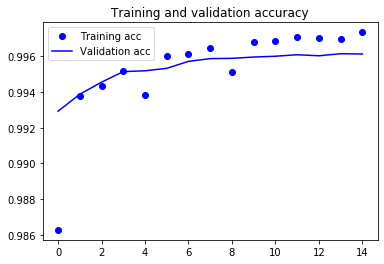

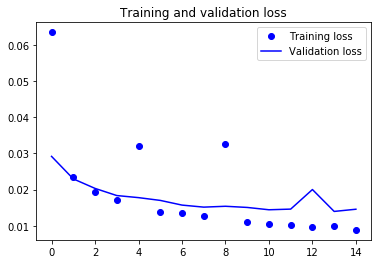

In [47]:
plot_perf()

Apply your network to one sentence.

In [48]:
sentence = 'The United States might collapsez'.lower().split()

First convert the sentence into indices

In [49]:
sentence_idx = [word2idx.get(w, 1) for w in sentence]
print("Sentence ", sentence)
print("Sentence word indexes ", sentence_idx)

Sentence  ['the', 'united', 'states', 'might', 'collapsez']
Sentence word indexes  [359698, 374678, 344404, 246008, 1]


Apply the prediction

In [50]:
ner_hat = model.predict(sentence_idx)
print(ner_hat.shape)
for i in range(ner_hat.shape[0]):
    indices = np.argmax(ner_hat[i], axis=1)
    print(sentence[i], ": ", idx2ner.get(indices[0], "unknown"))

(5, 1, 11)
the :  O
united :  I-LOC
states :  unknown
might :  O
collapsez :  unknown


## Evaluating your System

You will now evaluate the performance of your system on the whole test set. You will use the official script.
<ol>
    <li>Use the <tt>predict</tt> method to predict the tags of the whole test set
    </li>
    <li>Write your results in a file, where the two last columns will be the hand-annotated tag
        and the predicted tag. The fields must be separated by a space and each line must end with a new line:
        <tt>\n</tt>.
    </li>
    <li>
        If you save your results on a Windows machine, Python will use the default end-of-line sequence: <tt>\r\n</tt>.
        You will then need either to convert your file or to modify the way you save your file.
    </li>
    <li>Apply <tt>conlleval</tt> to your output. Report the F1 result.<br/>
        Be aware that <tt>conlleval</tt> was designed for Unix and will break
    with Windows end-of-line conventions.</li>
    <li>Try to improve your model by modifying some parameters, adding layers, adding
        <tt>Bidirectional</tt>
        and <tt>Dropout</tt>.
    </li>
    <li>
        Evaluate your network again
    </li>
</ol>

First translate the input part of the test set, the words, into lists of words, `X_test`, lists of indices, `X_test_idx`, and a matrix of indices, where you will pad the sequences: `X_test_padded`

In [51]:
# Test
X_test, Y_test = build_sequences(test_dict, key_x='form', key_y='ner')
print('X_test:', X_test[1])
print('Y_test', Y_test[1])

X_test: ['soccer', '-', 'japan', 'get', 'lucky', 'win', ',', 'china', 'in', 'surprise', 'defeat', '.']
Y_test ['O', 'O', 'B-LOC', 'O', 'O', 'O', 'O', 'B-PER', 'O', 'O', 'O', 'O']


In [52]:
X_test_idx, Y_test_idx = parallel_sequence_indexes(X_test, Y_test)
X_test_padded = pad_sequences(X_test_idx, maxlen=150)
Y_test_padded = pad_sequences(Y_test_idx, maxlen=150)
y_test = encode_y(Y_test_padded)

In [53]:
print('X_test_idx:', X_test_idx[1])
print('X_test_padded:', X_test_padded[1])

X_test_idx: [338644, 679, 197600, 162137, 229067, 390518, 517, 100680, 190291, 350949, 120818, 936]
X_test_padded: [     0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0     

Now predict the whole test set with `predict` and set the results in `Y_test_hat`

In [54]:
Y_test_hat = model.predict(X_test_padded)

In [55]:
print('X_test', X_test[1])
print('X_test_padded', X_test_padded[1])
print('Predictions', Y_test_hat[0])

X_test ['soccer', '-', 'japan', 'get', 'lucky', 'win', ',', 'china', 'in', 'surprise', 'defeat', '.']
X_test_padded [     0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0    

Extract the indices of the highest probabilities from the lists and convert them into NER values. Add them with the `pner` key to the dictionaries in the `test_dict` list.

In [56]:
def pner2dict(Y_test_padded, Y_test_hat):
    for i in range(Y_test_hat.shape[0]):
        sentence = np.argmax(Y_test_hat[i], axis=1)
        idx = 0
        for j in range(150):
            if Y_test_padded[i][j] in {0}:
                continue
            ner = idx2ner.get(sentence[j], 'unknown')
            test_dict[i][idx]['pner'] = ner
            idx += 1
    return test_dict

In [57]:
test_dict = pner2dict(Y_test_padded, Y_test_hat)

In [107]:
def save(file, corpus_dict, column_names):
    """
    Saves the corpus in a file
    :param file:
    :param corpus_dict:
    :param column_names:
    :return:
    """
    i = 0
    with open(file, 'w', encoding='utf8') as f_out:
        i += 1
        for sentence in corpus_dict:
            sentence_lst = []
            for row in sentence:
                items = map(lambda x: row.get(x, '_'), column_names)
                sentence_lst += ' '.join(items) + '\n'
            sentence_lst += '\n'
            f_out.write(''.join(sentence_lst))

In [108]:
def evaluate(ARCH):
    outfile = 'test' + ARCH + '.out'
    column_names = ['form', 'ppos', 'pchunk', 'ner', 'pner']
    save(outfile, test_dict, column_names)
    lines = open(outfile, encoding='utf8').read().splitlines()
    res = conlleval.evaluate(lines)
    baseline_score = res['overall']['chunks']['evals']['f1']
    return baseline_score

In [60]:
baseline_score1 = evaluate('1')
baseline_score1 

0.7428318584070797

## Optimized RNN

In [69]:
model = Sequential()
model.add(Embedding(M, N, weights = [embedding_matrix], trainable = False))
model.add(Bidirectional(SimpleRNN(N, return_sequences=True)))
model.add(Dropout(0.2))
model.add(Dense(nmClasses, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()
history = model.fit(X_idx, y_train, batch_size=32, epochs = EPOCHS, validation_data=(X_dev_idx, y_dev))

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 100)         40259700  
_________________________________________________________________
bidirectional_2 (Bidirection (None, None, 200)         40200     
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 200)         0         
_________________________________________________________________
dense_4 (Dense)              (None, None, 11)          2211      
Total params: 40,302,111
Trainable params: 42,411
Non-trainable params: 40,259,700
_________________________________________________________________
Epoch 1/15
469/469 [==============================] - 34s 72ms/step - loss: 0.0611 - accuracy: 0.9860 - val_loss: 0.0317 - val_accuracy: 0.9909
Epoch 2/15
469/469 [==============================] - 34s 72ms/step - loss: 0.0264 - accura

In [70]:
model.save('model2.h5')

In [71]:
model = load_model('model2.h5')

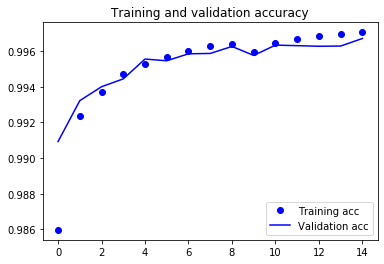

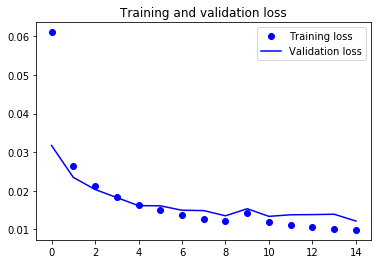

In [72]:
plot_perf()

In [73]:
Y_test_hat = model.predict(X_test_padded)
test_dict = pner2dict(Y_test_padded, Y_test_hat)

In [74]:
baseline_score2 = evaluate('2')
baseline_score2

0.7938849880010665

## Building a LSTM Network

1. Create a simple LSTM network and train a model with the train set. As layers, you will use <tt>Embedding</tt>, <tt>LSTM</tt>, and <tt>Dense</tt>.
2. Apply conlleval to your output. Report the F1 result.
3. Try to improve your model by modifying some parameters, adding layers, adding <tt>Bidirectional</tt>, <tt>Dropout</tt>, possibly mixing <tt>SimpleRNN</tt>.
4. Apply your network to the test set and report the accuracy you obtained. you need to reach a F1 of 82 to pass.

In [75]:
model = Sequential()
model.add(Embedding(M, N,
              weights=[embedding_matrix],
              trainable=False))
model.add(LSTM(units=LSTM_UNITS, return_sequences=True, input_shape = (M, N)))
model.add(Dense(nmClasses, activation='softmax'))

In [76]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 100)         40259700  
_________________________________________________________________
lstm (LSTM)                  (None, None, 100)         80400     
_________________________________________________________________
dense_5 (Dense)              (None, None, 11)          1111      
Total params: 40,341,211
Trainable params: 81,511
Non-trainable params: 40,259,700
_________________________________________________________________


Compile and fit it

In [77]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_idx, y_train, epochs = EPOCHS, validation_data=(X_dev_idx, y_dev))

Epoch 1/15
469/469 [==============================] - 5s 11ms/step - loss: 0.0760 - accuracy: 0.9857 - val_loss: 0.0270 - val_accuracy: 0.9932
Epoch 2/15
469/469 [==============================] - 5s 10ms/step - loss: 0.0194 - accuracy: 0.9947 - val_loss: 0.0183 - val_accuracy: 0.9952
Epoch 3/15
469/469 [==============================] - 5s 11ms/step - loss: 0.0145 - accuracy: 0.9958 - val_loss: 0.0157 - val_accuracy: 0.9958
Epoch 4/15
469/469 [==============================] - 5s 10ms/step - loss: 0.0124 - accuracy: 0.9964 - val_loss: 0.0142 - val_accuracy: 0.9961
Epoch 5/15
469/469 [==============================] - 5s 10ms/step - loss: 0.0110 - accuracy: 0.9968 - val_loss: 0.0147 - val_accuracy: 0.9961
Epoch 6/15
469/469 [==============================] - 5s 11ms/step - loss: 0.0100 - accuracy: 0.9971 - val_loss: 0.0140 - val_accuracy: 0.9962
Epoch 7/15
469/469 [==============================] - 5s 11ms/step - loss: 0.0091 - accuracy: 0.9973 - val_loss: 0.0130 - val_accuracy: 0.9964

In [78]:
model.save('model3.h5')

In [125]:
model = load_model('model3.h5')

Create a figure to show the training and validation losses and accuracies and comment on a possible overfit.

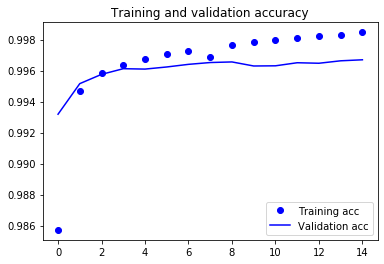

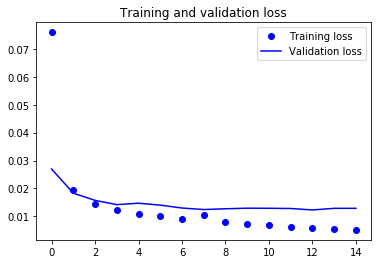

In [80]:
plot_perf()

Predict the NER sequence

In [126]:
Y_test_hat = model.predict(X_test_padded)

Extract the indices of the highest probabilities from the lists and convert them into NER values. Add them with the `pner` key to the dictionaries in the `test_dict` list.

In [127]:
test_dict = pner2dict(Y_test_padded, Y_test_hat)

In [128]:
baseline_score3 = evaluate('3')
baseline_score3

0.7664482306684142

You need to reach 82 to pass the assignment.

## Optimized LSTM

In [160]:
model = Sequential()
model.add(Embedding(M, N, weights = [embedding_matrix], trainable = False))
model.add(Bidirectional(LSTM(units=LSTM_UNITS, return_sequences=True, dropout=0.15, recurrent_dropout=0.1)))
# model.add(Dropout(0.15))
model.add(Dense(nmClasses, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()
history = model.fit(X_idx, y_train, epochs = EPOCHS, validation_data=(X_dev_idx, y_dev))

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (None, None, 100)         40259700  
_________________________________________________________________
bidirectional_14 (Bidirectio (None, None, 200)         160800    
_________________________________________________________________
dropout_14 (Dropout)         (None, None, 200)         0         
_________________________________________________________________
dense_21 (Dense)             (None, None, 11)          2211      
Total params: 40,422,711
Trainable params: 163,011
Non-trainable params: 40,259,700
_________________________________________________________________
Epoch 1/15
469/469 [==============================] - 8s 18ms/step - loss: 0.0841 - accuracy: 0.9827 - val_loss: 0.0329 - val_accuracy: 0.9905
Epoch 2/15
469/469 [==============================] - 8s 17ms/step - loss: 0.0251 - accura

In [161]:
model.save('model4.h5')

In [162]:
model = load_model('model4.h5')

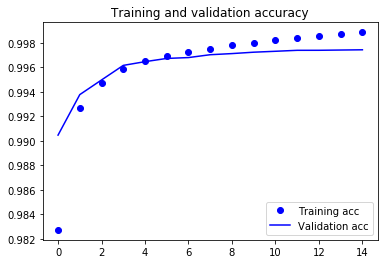

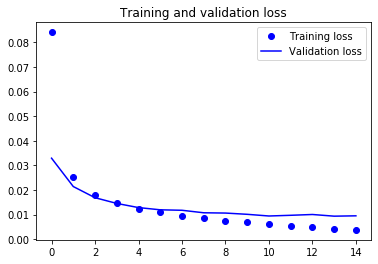

In [163]:
plot_perf()

In [164]:
Y_test_hat = model.predict(X_test_padded)
test_dict = pner2dict(Y_test_padded, Y_test_hat)

In [165]:
baseline_score4 = evaluate('4')
baseline_score4

0.8309314586994727

In [166]:
print("F1:")
print('Simple RNN : ', baseline_score1)
print('Optimized RNN : ', baseline_score2)
print('Simple LSTM : ', baseline_score3)
print('Optimized LSTM : ', baseline_score4)

F1:
Simple RNN :  0.7428318584070797
Optimized RNN :  0.7938849880010665
Simple LSTM :  0.7664482306684142
Optimized LSTM :  0.8309314586994727
